Install Libraries

In [ ]:
!pip install imbalanced-learn

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import imblearn

Import Dataset

In [2]:
df = pd.read_csv('dataset.csv')
# df.head(1)

len(df[(df["is_ne"].notnull())])


1696

In [3]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23150 entries, 0 to 23149
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   word_id              23150 non-null  int64 
 1   sentence_id          23150 non-null  int64 
 2   word                 23134 non-null  object
 3   label                23150 non-null  object
 4   is_ne                1696 non-null   object
 5   is_spelling_correct  23150 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 927.0+ KB


Data Cleaning

In [4]:

# print(len(df))
def drop_null_words(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(subset=['word'])
    df_cleaned = df_cleaned.reset_index(drop=True)
    return df_cleaned

df = drop_null_words(df)

# Dropping named entities
df = df[df['is_ne'].isnull()]

# df['is_ne']

Feature Engineering / Preprocessing:

Target Features:
 - Word length
 - Vowel / Word Ratio
 - Consonant / Word Ratio
 - Look at common letters not present in filipino word (c, x, z, f, etc.)
 - Common NGram counts for Filipino and English words
    - ng
    - ch, sh, etc.
    - Filipino prefixes (um, in, etc.)
-  Check if the word is a (noun, verb, etc based on the sentence)

More features helping English prediction


Note: normalize data if needed (check sklearn.preprocessing)

In [5]:
len(df["is_spelling_correct"])

21438

Length Feature

In [6]:
df['word_length'] = df['word'].apply(lambda w: len(str(w)) if isinstance(w, str) else 0)
df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length
0,45,1,Gusto,FIL,NaN,True,5


Vowel and consonant ratio

In [7]:
def vowel_consonant_ratio(word):
    if not isinstance(word, str):  ### if the word does not have alphabet
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return (1-num_vowels / num_consonants)

def vowel_word_ratio(word):
    if not isinstance(word, str):
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return num_vowels / num_consonants

df['vowel_word_ratio'] = df['word'].apply(vowel_word_ratio)
df['vowel_consonant_ratio'] = df['word'].apply(vowel_consonant_ratio)

df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio
0,45,1,Gusto,FIL,NaN,True,5,0.4,0.6


Bigram

In [8]:
filipino_bigrams = ['ng', 'ka', 'in', 'ay', 'um', 'mag', 'nag', 'may', 'na', 'sa']

def count_filipino_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['filipino_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, filipino_bigrams)
)

df.head()

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count
0,45,1,Gusto,FIL,NaN,True,5,0.40,0.60,0
1,46,1,kong,FIL,NaN,True,4,0.25,0.75,1
2,47,1,intindihin,FIL,NaN,True,10,0.40,0.60,3
3,48,1,pero,FIL,NaN,True,4,0.50,0.50,0
4,49,1,hindi,FIL,NaN,True,5,0.40,0.60,1


In [9]:
# ORIGINAL
english_bigrams = [
    'th', 'sh', 'ch', 'wh', 'ed', 'ly', 'er', 
    'es', 'ou', 'ea', 'io', 'al', 'is', 'at', 
    'an', 'he', 'lk', 'tr' 
]
# # YOUR MODIFICATION
# english_bigrams = [
    # 'th', 'sh', 'ch', 'wh', 'ed', 'er', 
    # 'es', 'ou', 'ea', 'io',  
    # 'he', 'lk' 
# ]
# TEST

# # Possible omissions (APPLIED)
# ly, al, is, on, an, tr
# es

def count_english_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['english_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, english_bigrams)
)

print("English: ", len(df[(df['label'] == 'ENG') & (df['english_bigram_count'] > 0)]))
# df[(df['label'] == 'FIL') & (df['english_bigram_count'] > 0)]
print("Filipino : ",len(df[(df['label'] == 'FIL') & (df['english_bigram_count'] > 0)]))

English:  799
Filipino :  6404


Foreign Alphabet

In [10]:
foreign_letters = ['c', 'f', 'j', 'q', 'v', 'x', 'z']

def check_foreign_alphabet(word: str) -> int:
    word_lower = str(word).lower()

    for letter in word_lower:
        if letter in foreign_letters:
            return 1
    return 0

df['has_foreign_alphabet'] = df['word'].apply(check_foreign_alphabet)
df.head()

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count,has_foreign_alphabet
0,45,1,Gusto,FIL,NaN,True,5,0.40,0.60,0,0,0
1,46,1,kong,FIL,NaN,True,4,0.25,0.75,1,0,0
2,47,1,intindihin,FIL,NaN,True,10,0.40,0.60,3,0,0
3,48,1,pero,FIL,NaN,True,4,0.50,0.50,0,1,0
4,49,1,hindi,FIL,NaN,True,5,0.40,0.60,1,0,0


In [ ]:
# Word in context of sentence
# # Maybe context doesn't help?

Tagalog noun affix check \
    - Check if it contains affixes denoted below \
    - Affixes: ka- -an, pang-, taga-, mag- 

In [11]:
def tagalog_xfix_check(word : str) -> int:
    prefix = tuple(['ka' ,'pang', 'taga', 'mag', 'nag'])
    affix = tuple(['an', 'ng', 'ero', 'era'])

    if (word.startswith(prefix) or word.endswith(affix)):
        return 1
    else: return 0


    # return 

# tagalog_xfix_check("fuck")
df['has_tagalog_xfix']= df['word'].apply(tagalog_xfix_check)
# df[(df['has_tagalog_xfix'] == 1) & (df['label'] == 'ENG')]
# 
df.head(15)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count,has_foreign_alphabet,has_tagalog_xfix
0,45,1,Gusto,FIL,NaN,True,5,0.400000,0.600000,0,0,0,0
1,46,1,kong,FIL,NaN,True,4,0.250000,0.750000,1,0,0,1
2,47,1,intindihin,FIL,NaN,True,10,0.400000,0.600000,3,0,0,0
3,48,1,pero,FIL,NaN,True,4,0.500000,0.500000,0,1,0,1
4,49,1,hindi,FIL,NaN,True,5,0.400000,0.600000,1,0,0,0
5,50,1,ko,FIL,NaN,True,2,0.500000,0.500000,0,0,0,0
6,51,1,maintindihan,FIL,NaN,True,12,0.416667,0.583333,2,1,0,1
8,53,1,paano,FIL,NaN,True,5,0.600000,0.400000,0,1,0,0
9,54,1,ba,FIL,NaN,True,2,0.500000,0.500000,0,0,0,0
10,55,1,itong,FIL,NaN,True,5,0.400000,0.600000,1,0,0,1


Train Test Split

- Check the sklearn to split.
- Model should be 80-20 split

In [12]:
# feature_cols = ['has_tagalog_xfix','vowel_word_ratio', 'vowel_consonant_ratio',
#                 'filipino_bigram_count', 'english_bigram_count', 'has_foreign_alphabet']
feature_cols = ['has_tagalog_xfix','vowel_word_ratio', 'vowel_consonant_ratio',
                'filipino_bigram_count', 'english_bigram_count', 'has_foreign_alphabet']
X = df[feature_cols]
y = df['label']
print(len(X),len(y))

21438 21438


In [13]:
from sklearn.model_selection import train_test_split

## Split the dataset to 15% test size and 85% train and validation size
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Split the train and validation set to 15% validation size and 85% train size
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

print("X_train: ",  len(X_train))
print("X_val: ", len(X_val))
print("y_train: ", len(y_train))
print("y_val: ", len(y_val))

X_train:  15005
X_val:  3217
y_train:  15005
y_val:  3217


Imbalance Data:

Check these techniques in imblearn library:
 - SMOTE
 - ADYSN
 - Undersampling
 - Oversampling

SMOTE Sampling

In [ ]:
from imblearn.over_sampling import SMOTE


smote_sampler = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote_sampler.fit_resample(
    X_train, 
    y_train
)
print("Original training set size:", len(y_train))
print("Resampled training set size:", len(y_train_resampled))

Naive Oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Original training set size", len(y_train))
print(len((y_train_resampled)))

Original training set size 15005
37080


Naive Undersampling

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=42)

X_train_resampled, y_train_resampled = cc.fit_resample(X_train, y_train)

print("Original training set size", len(y_train))
print(len((y_train_resampled)))


ML Modelling

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_val_pred = nb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")

## Hypertune by changing model parameters if needed (var_smoothing for GaussianNB)


Decision Trees

In [15]:
from sklearn import tree
from sklearn.metrics import accuracy_score

# clf = tree.DecisionTreeClassifier(splitter='random')
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_resampled, y_train_resampled)

y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")



Validation Set Accuracy: 0.9301


Model Validation:
- Confusion Matrix
- Classification report

Naive Bayes Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

Decision Trees Evaluation

Test Set Accuracy: **0.9307**

Classification Report:
              precision    recall  f1-score   support

         ENG       0.56      0.71      0.62       257
         FIL       0.97      0.95      0.96      2652
         OTH       0.99      0.99      0.99       307

    accuracy                           0.93      3216
   macro avg       0.84      0.88      0.86      3216
weighted avg       0.94      0.93      0.93      3216



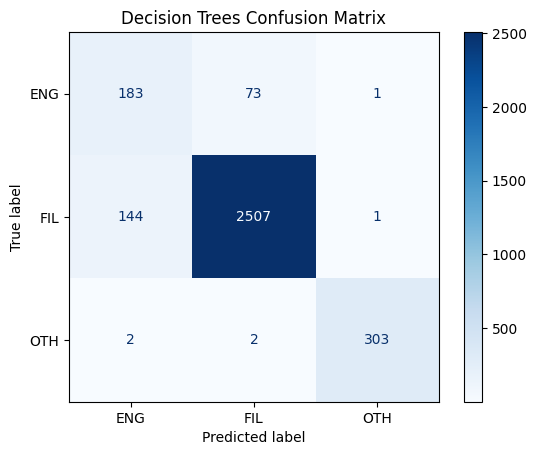

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

label = ['ENG', 'FIL', 'OTH']

cm = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Trees Confusion Matrix")
plt.show()